In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from src.preprocessing import display_missing_values
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_theme(style="ticks", palette="pastel")

from sklearn.preprocessing import PolynomialFeatures, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
from fonctions import Dataset, group_fuel_types


In [3]:
train=Dataset("data/train.csv")
data_train=train.load_data()
test=Dataset("data/test.csv")
data_test=test.load_data()

In [4]:
from fonctions import Preprocessor,TrainPreprocessor,TestPreprocessor
train_preprocessor=TrainPreprocessor(data_train)
test_preprocessor=TestPreprocessor(data_test)

In [5]:
variables_continues=["Fuel consumption ","Electric range (km)","ec (cm3)","z (Wh/km)","W (mm)"]

In [6]:
train_preprocessor.fill_fuel_consumption()
train_preprocessor.fill_electric_range()
train_preprocessor.fill_engine_capacity()
train_preprocessor.fill_electric_consumption()
train_preprocessor.fill_category_type()
train_preprocessor.fill_wheel_base()
train_preprocessor.fill_At_1()
train_preprocessor.fill_At_2()
train_preprocessor.fill_mass()
train_preprocessor.fill_engine_power()
train_preprocessor.encode_country()
train_preprocessor.encode_manufacture_pooling()
train_preprocessor.encode_fuel_mode()
train_preprocessor.encode_fuel_type()
train_preprocessor.encode_category_registered()
train_preprocessor.encode_category_type()
train_preprocessor.last_step()

test_preprocessor.fill_fuel_consumption()
test_preprocessor.fill_electric_range()
test_preprocessor.fill_engine_capacity()
test_preprocessor.fill_electric_consumption()
test_preprocessor.fill_category_type()
test_preprocessor.fill_wheel_base()
test_preprocessor.fill_At_1()
test_preprocessor.fill_At_2()
test_preprocessor.fill_mass()
test_preprocessor.fill_engine_power()
test_preprocessor.encode_country()
test_preprocessor.encode_manufacture_pooling()
test_preprocessor.encode_fuel_mode()
test_preprocessor.encode_fuel_type()
test_preprocessor.encode_category_registered()
test_preprocessor.encode_category_type()
test_preprocessor.last_step()

In [7]:
data_train["Mp"].nunique()

11

In [8]:
# scaler=StandardScaler()

In [9]:
# data_train[variables_continues]=scaler.fit_transform(data_train[variables_continues])

In [10]:
# data_test[variables_continues]=scaler.transform(data_test[variables_continues])

### Test de non-linéarité des variables quantitatives 

In [11]:
others=[col for col in data_train.columns if col not in variables_continues]

In [12]:
# poly = PolynomialFeatures(degree=2,)

# # Application de la transformation aux variables continues
# variables_continues_transformees = poly.fit_transform(data_train[variables_continues])

# data_train_transforme = pd.DataFrame(variables_continues_transformees, columns=poly.get_feature_names_out(variables_continues))
# data_train= pd.concat([data_train[others],data_train_transforme], axis=1)



In [13]:
# variables_continues_transformees = poly.fit_transform(data_test[variables_continues])

# data_test_transforme = pd.DataFrame(variables_continues_transformees, columns=poly.get_feature_names_out(variables_continues))
# data_test= pd.concat([data_test[list(filter(lambda x: x !='Ewltp (g/km)',others))],data_train_transforme], axis=1)

In [14]:
def create_conforme(df):
    # df['conforme'] = df['Tan'].isna()
    df['conforme'] = df['Tan'].apply(lambda x: 1 if x else 0)
    df.drop(columns='Tan', inplace=True)
    pass

def compute_surface(obs):
    max_largeur= max(obs['At1 (mm)'], obs['At2 (mm)'])
    return obs['W (mm)']*obs['At1 (mm)'] if max_largeur == obs['At1 (mm)'] else obs['W (mm)'] * obs['At2 (mm)']

compute_surface_bis=lambda obs: obs['W (mm)']*(obs['At1 (mm)']+ obs['At2 (mm)'])/2

def create_surface(df):
    df['surface']= df.apply(compute_surface_bis, axis=1)
    pass

In [15]:
create_conforme(data_train)
create_surface(data_train)

create_conforme(data_test)
create_surface(data_test)

In [16]:
drop_this=['VFN', 'Mh','Man', 'T', 'Mk', 'Cn','Mt','W (mm)', 'At1 (mm)', 'At2 (mm)','Fm','Erwltp (g/km)']

data_train.drop(columns=drop_this, inplace=True)
data_test.drop(columns=drop_this, inplace=True)

In [17]:
data_train.drop(columns='ID',inplace=True)

In [18]:
data_train

,Country,Mp,Ct,Cr,m (kg),Ewltp (g/km),Ft,ep (KW),1,Fuel consumption,Electric range (km),ec (cm3),z (Wh/km),Fuel consumption ^2,Fuel consumption Electric range (km),Fuel consumption ec (cm3),Fuel consumption z (Wh/km),Fuel consumption W (mm),Electric range (km)^2,Electric range (km) ec (cm3),Electric range (km) z (Wh/km),Electric range (km) W (mm),ec (cm3)^2,ec (cm3) z (Wh/km),ec (cm3) W (mm),z (Wh/km)^2,z (Wh/km) W (mm),W (mm)^2,conforme,surface
0,5,1,0.00,0.00,1387.00,401.05,8.00,92.00,1.00,5.60,0.00,999.00,0.00,31.36,0.00,5594.40,0.00,15120.00,0.00,0.00,0.00,0.00,998001.00,0.00,2697300.00,0.00,0.00,7290000.00,1,4248450.00
1,10,10,0.00,0.00,1172.00,394.68,8.00,70.00,1.00,5.50,0.00,999.00,0.00,30.25,0.00,5494.50,0.00,14036.00,0.00,0.00,0.00,0.00,998001.00,0.00,2549448.00,0.00,0.00,6512704.00,1,3806308.00
2,10,10,0.00,0.00,1204.00,398.56,8.00,70.00,1.00,5.60,0.00,999.00,0.00,31.36,0.00,5594.40,0.00,14291.20,0.00,0.00,0.00,0.00,998001.00,0.00,2549448.00,0.00,0.00,6512704.00,1,3806308.00
3,5,3,0.00,0.00,1438.00,479.47,8.00,150.00,1.00,6.80,0.00,1591.00,0.00,46.24,0.00,10818.80,0.00,18020.00,0.00,0.00,0.00,0.00,2531281.00,0.00,4216150.00,0.00,0.00,7022500.00,1,4131350.00
4,10,10,0.00,0.00,1207.00,421.85,8.00,81.00,1.00,5.90,0.00,999.00,0.00,34.81,0.00,5894.10,0.00,15056.80,0.00,0.00,0.00,0.00,998001.00,0.00,2549448.00,0.00,0.00,6512704.00,1,3806308.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7571644,10,10,0.00,0.00,1815.00,481.85,0.00,120.00,1.00,5.90,0.00,1968.00,0.00,34.81,0.00,11611.20,0.00,16691.10,0.00,0.00,0.00,0.00,3873024.00,0.00,5567472.00,0.00,0.00,8003241.00,1,4594296.00
7571645,10,10,0.00,0.00,1815.00,486.40,0.00,120.00,1.00,5.90,0.00,1968.00,0.00,34.81,0.00,11611.20,0.00,16691.10,0.00,0.00,0.00,0.00,3873024.00,0.00,5567472.00,0.00,0.00,8003241.00,1,4594296.00
7571646,10,10,0.00,0.00,1815.00,487.87,0.00,120.00,1.00,5.90,0.00,1968.00,0.00,34.81,0.00,11611.20,0.00,16691.10,0.00,0.00,0.00,0.00,3873024.00,0.00,5567472.00,0.00,0.00,8003241.00,1,4594296.00
7571647,16,6,0.00,0.00,1240.00,350.80,5.00,68.00,1.00,6.20,0.00,999.00,0.00,38.44,0.00,6193.80,0.00,15655.00,0.00,0.00,0.00,0.00,998001.00,0.00,2522475.00,0.00,0.00,6375625.00,1,3825375.00


In [19]:
list_vars=["Ewltp (g/km)", "m (kg)","ec (cm3)", "ep (KW)", "z (Wh/km)", "Fuel consumption ","Electric range (km)", "surface"]

<function matplotlib.pyplot.show(close=None, block=None)>

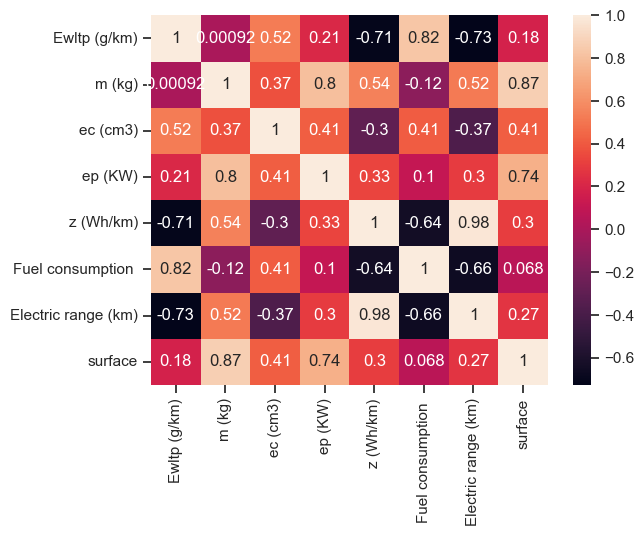

<Figure size 2000x2000 with 0 Axes>

In [20]:
sns.heatmap(data_train[list_vars].corr(method='spearman'),annot=True)
plt.figure(figsize=(20,20))
plt.show

In [21]:
# num_rows = 2
# num_cols = 4

# # Creating subplots
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# # Flatten the axes array for easy iteration
# axes = axes.flatten()

# # Plotting scatter plots
# for i, var in enumerate(list_vars):
#     if var != "Ewltp (g/km)":
#         axes[i].scatter(data_train[var], data_train["Ewltp (g/km)"])
#         axes[i].set_title(f"Scatter plot between {var} and Ewltp (g/km)")
#         axes[i].set_xlabel(var)
#         axes[i].set_ylabel("Ewltp (g/km)")

# # Adjust layout to prevent clipping
# plt.tight_layout()
# plt.show()

In [22]:
# data_train.drop(columns=['z (Wh/km)',"m (kg)","surface"],inplace=True)
# data_test.drop(columns=['z (Wh/km)',"m (kg)","surface"],inplace=True)

### Exploratory Data Analysis

In [23]:
from sklearn.linear_model import LassoCV, ElasticNetCV

In [24]:
train, test = train_test_split(data_train, test_size=0.33, random_state=0,)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

X_train, y_train = train.drop(columns=["Ewltp (g/km)"]), train["Ewltp (g/km)"]
X_test, y_test = test.drop(columns=["Ewltp (g/km)"]), test["Ewltp (g/km)"]

In [25]:
lasso = LassoCV(cv=5,)
lasso.fit(X_train, y_train)

# Affichez les coefficients sélectionnés
selected_features = X_train.columns[lasso.coef_ != 0]
print("Variables sélectionnées par Adaptive LASSO :")
print(selected_features)

Variables sélectionnées par Adaptive LASSO :
Index(['Electric range (km) W (mm)', 'ec (cm3)^2', 'ec (cm3) W (mm)',
       'z (Wh/km) W (mm)', 'W (mm)^2', 'surface'],
      dtype='object')


In [26]:
# elastic_net = ElasticNetCV(cv=5, random_state=42, l1_ratio=0.8)
# elastic_net.fit(X_train, y_train)

# # Affichez les coefficients sélectionnés
# selected_features = X_train.columns[elastic_net.coef_ != 0]
# print("Variables sélectionnées par Adaptive LASSO :")
# print(selected_features)

In [27]:
import xgboost as xgb

In [28]:
import numba
from numba import cuda

In [29]:
@numba.jit
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

C:\Users\jeann\AppData\Local\Temp\ipykernel_21428\13295361.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def evaluate_model(model, X_test, y_test):


In [30]:
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [31]:
# space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#         'gamma': hp.uniform ('gamma', 1,9),
#         'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
#         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
#         'n_estimators': 1000,
#         'seed': 0
#     }

In [32]:
# space_bis={'max_depth': hp.quniform("max_depth", 3, 18, 1),
#            'n_estimators': 1500,
#            'learning_rate':hp.uniform("learning_rate",0.1,0.30)
#            }

In [33]:
# @numba.jit
# def objective(space):
#     clf=xgb.XGBRegressor(objective="reg:squarederror",
#                     n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
#                     reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
#                     colsample_bytree=int(space['colsample_bytree']), eval_metric="mae")
    
#     evaluation = [( X_train, y_train), ( X_test, y_test)]
    
#     clf.fit(X_train, y_train,
#             eval_set=evaluation,
#             verbose=False)
    

#     y_pred = clf.predict(X_test)
#     mae = mean_absolute_error(y_test, y_pred)
#     print ("SCORE:", mae)
#     return {'loss': mae, 'status': STATUS_OK }

In [34]:
# @numba.jit
# def objective_bis(space):
#     clf=xgb.XGBRegressor(objective="reg:squarederror",
#                     n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), eval_metric="mae")
    
#     evaluation = [( X_train, y_train), ( X_test, y_test)]
    
#     clf.fit(X_train, y_train,
#             eval_set=evaluation,
#             verbose=False)
    

#     y_pred = clf.predict(X_test)
#     mae = mean_absolute_error(y_test, y_pred)
#     print ("SCORE:", mae)
#     return {'loss': mae, 'status': STATUS_OK }

In [35]:
# trials = Trials()

# best_hyperparams = fmin(fn = objective_bis,
#                         space = space_bis,
#                         algo = tpe.suggest,
#                         max_evals = 1000,
#                         trials = trials)

In [36]:
@numba.jit
def train_xgboost(X:np.array,y:np.array,n_estimators=2000 ,objective='reg:squarederror',max_depth=10, learning_rate=0.2):
    xgboost_model=xgb.XGBRegressor(n_estimators=n_estimators ,objective=objective, 
                                   max_depth=max_depth,learning_rate=learning_rate, n_jobs=-1,)
                                    #subsample=0.75,tree_method="gpu_hist", device="cuda", eval_metric="mae",reg_alpha=0.1,reg_lambda=0.1,booster="gblinear")
    xgboost_model.fit(X, y)
    return xgboost_model

In [37]:
xgboost_model=train_xgboost(X_train,y_train)

In [38]:
mae=evaluate_model(xgboost_model,X_test,y_test)

C:\Users\jeann\AppData\Local\Temp\ipykernel_21428\13295361.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "evaluate_model" failed type inference due to: Untyped global name 'mean_absolute_error': Cannot determine Numba type of <class 'function'>

File "..\..\..\..\AppData\Local\Temp\ipykernel_21428\13295361.py", line 4:
<source missing, REPL/exec in use?>

  @numba.jit
c:\Users\jeann\Desktop\M2\New Data Mining Challenge\Projet_Mining\.venv_mining\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "evaluate_model" was compiled in object mode without forceobj=True.

File "..\..\..\..\AppData\Local\Temp\ipykernel_21428\13295361.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
c:\Users\jeann\Desktop\M2\New Data Mining Challenge\Projet_Mining\.venv_mining\lib\site-packages\numba\core\object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopy

In [39]:
mae

3.2177936326044922

In [41]:
rf_model=RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae_rf)

Mean Absolute Error (MAE): 3.177313697212825


In [ ]:
# @numba.jit
# def grid_search(list_estimators,list_depth,list_rate):
#     output={}
#     output["estimators"]=[]
#     output["depth"]=[]
#     output["rate"]=[]
#     for n_estimators in list_estimators:
#         for max_depth in list_depth:
#             for learning_rate in list_rate:
#                 xgboost_model=train_xgboost(X_train,y_train,n_estimators=n_estimators,max_depth=max_depth,learning_rate=learning_rate)
#                 mae=evaluate_model(xgboost_model,X_test,y_test)
#                 output["estimators"].append(n_estimators)
#                 output["depth"].append(max_depth)
#                 output["rate"].append(learning_rate)
#     return output


In [ ]:
# estimators=[500,1000,1500,2000]
# depths=[8,10,12,14]
# rates=[0.01,0.05,0.1,0.15,0.2]


In [ ]:
# output=grid_search(estimators,depths,rates)

In [ ]:
# from joblib import Parallel, delayed

# def evaluate_model(model, X_test, y_test):
#     y_pred = model.predict(X_test)
#     mae = mean_absolute_error(y_test, y_pred)
#     return mae

# def train_xgboost(X, y, n_estimators=1500, objective='reg:squarederror', max_depth=10, learning_rate=0.2):
#     xgboost_model = xgb.XGBRegressor(n_estimators=n_estimators, objective=objective,
#                                      max_depth=max_depth, learning_rate=learning_rate, n_jobs=-1)
#     xgboost_model.fit(X, y)
#     return xgboost_model

# def grid_search(n_estimators_list, max_depth_list, learning_rate_list, X_train, y_train, X_test, y_test):
#     global results
#     results = []

#     def evaluate_params(n_estimators, max_depth, learning_rate):
#         xgboost_model = train_xgboost(X_train, y_train, n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
#         mae = evaluate_model(xgboost_model, X_test, y_test)
#         return {'estimators': n_estimators, 'depth': max_depth, 'rate': learning_rate, 'mae': mae}

#     results = Parallel(n_jobs=-1)(
#         delayed(evaluate_params)(n, d, r) for n in n_estimators_list for d in max_depth_list for r in learning_rate_list
#     )

#     return results

In [ ]:
# output = grid_search(estimators, depths, rates, X_train, y_train, X_test, y_test)


In [ ]:
# mae_train=evaluate_model(xgboost_model,X_train,y_train)

In [ ]:
# print(f"La MAE sur le train est {mae_train} tandis que la MAE sur le test est {mae}.")

In [ ]:
# xgboost_model_full=train_xgboost(data_train.drop(columns=["Ewltp (g/km)"]),data_train["Ewltp (g/km)"])

In [ ]:
# X_true_test=data_test.drop(columns=["ID"])

In [ ]:
# data_train

In [ ]:
y_true_pred=xgboost_model.predict(X_true_test)

In [ ]:
data_test_to_submit=pd.concat([data_test["ID"],pd.DataFrame(y_true_pred,columns=["Ewltp (g/km)"])],axis=1)
data_test_to_submit.to_csv("data/output/xgboost_results11.csv", index=False)

In [ ]:

from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import make_scorer
model = xgb.XGBRegressor(objective="reg:squarederror")

# Définir la métrique MAE comme scorer
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Définir la validation croisée
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Effectuer la validation croisée avec la métrique MAE
scores = cross_val_score(model, X_train, y_train, scoring=scorer, cv=kfold)

# Afficher les résultats
print("Mean Absolute Error for each fold:", -scores)
print("Mean Absolute Error (average):", -scores.mean())


In [ ]:
rf_model=RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

In [ ]:
@numba.jit
def train_random_forest(X,y,): #n_estimators=1000,max_samples=10000 ,
    #rf_model=RandomForestRegressor(n_estimators=n_estimators, max_samples=max_samples ,criterion=criterion,max_depth=max_depth)
    rf_model=RandomForestRegressor(random_state=42, n_jobs=-1)
    rf_model.fit(X, y)
    return rf_model

In [ ]:
rf_model=train_random_forest(X_train,y_train)

In [ ]:
mae=evaluate_model(rf_model,X_test,y_test)
print("Mean Absolute Error:", mae)

In [ ]:
rf_model=RandomForestRegressor(random_state=42, n_jobs=-1)

In [ ]:
rf_model.fit(X_train, y_train)

In [ ]:
@numba.jit
def train_hist_gradient_boosting(X,y,max_iter=3500, learning_rate=0.15,max_depth=8):
    hgbgb_model=HistGradientBoostingRegressor(max_iter=max_iter, learning_rate=learning_rate, max_depth=max_depth,interaction_cst="pairwise")
    hgbgb_model.fit(X,y)
    return hgbgb_model

In [ ]:
hgbgb_model=train_hist_gradient_boosting(X_train,y_train)

In [ ]:
mae=evaluate_model(hgbgb_model,X_test,y_test)
print(f"Mean Absolute Error : {mae}")

In [ ]:
hgbgb_model.n_iter_

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor


In [ ]:
# Créez un modèle de régression de base (par exemple, un arbre de régression)
@numba.jit
def train_adaboost_regressor(max_depth=7,n_estimators=1000, learning_rate=.2, random_state=42) -> AdaBoostRegressor:
    base_regressor = DecisionTreeRegressor(max_depth=max_depth)

    # Créez un modèle AdaBoostRegressor en utilisant le modèle de base
    adaboost_regressor = AdaBoostRegressor(base_regressor, n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)

    # Entraînez le modèle AdaBoost sur l'ensemble d'entraînement
    adaboost_regressor.fit(X_train, y_train)
    return adaboost_regressor


In [ ]:
adaboost_model=train_adaboost_regressor()

mae=evaluate_model(adaboost_model,X_test,y_test)
print(f"Mean Absolute Error : {mae}")

In [ ]:
X_true_test=data_test.drop(columns=['ID'])

In [ ]:
data_test["ID"]=data_test["ID"].apply(int)

In [ ]:
data_test["Ewltp (g/km)"] = xgboost_model.predict(X_true_test)
data_test[["ID","Ewltp (g/km)"]].to_csv("data/xgboost_results4.csv", index=False)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dtregressor_model=DecisionTreeRegressor(criterion='absolute_error')

In [ ]:
dtregressor_model.fit(X_train, y_train)

# Prédisez sur les données de test
y_pred = dtregressor_model.predict(X_test)

# Évaluez le modèle en utilisant la MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

In [ ]:
import lightgbm as lgb

In [ ]:

# Créez un ensemble de données LightGBM
train_data = lgb.Dataset(X_train, label=y_train)

# Définissez les paramètres du modèle
params = {
    "objective": "regression",  # Régression
    "metric": "mae",  # Métrique d'erreur : Mean Absolute Error
    "boosting_type": "gbdt",  # Type de boosting (Gradient Boosting Decision Tree)
    "num_leaves": 31,  # Nombre maximum de feuilles dans un arbre
    "learning_rate": 0.1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 10,
    "verbose": -1
}

# Entraînez le modèle
num_round = 1000  # Nombre d'itérations (vous pouvez ajuster selon vos besoins)
bst = lgb.train(params, train_data, num_round)

# Faites des prédictions sur l'ensemble de test
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Évaluez le modèle
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (mae): {mae}")



In [ ]:
from tensorflow.keras.layers import Dense, Input

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
import tensorflow as tf

In [ ]:
ncol=X_train.shape[1]

In [ ]:
inputs=Input(shape=ncol, name="Input")
first_layer=Dense(units=64,activation='relu',kernel_initializer="normal",name="Dense_1")
second_layer=Dense(units=64,activation='relu',kernel_initializer='normal',name="Dense_2")
output_layer=Dense(units=1)

In [ ]:
outputs=output_layer(second_layer(first_layer(inputs)))
dnn_model=Model(inputs=inputs, outputs=outputs)

In [ ]:
dnn_model.summary()

In [ ]:
opt=tf.optimizers.Adam(learning_rate=0.1)
dnn_model.compile(optimizer=opt, loss="mean_absolute_error")
dnn_model.fit(X_train,y_train, epochs=20, batch_size=32, validation_split=0.2,)

In [ ]:
dnn_model.history

In [ ]:
dnn_model.evaluate(X_test,y_test, verbose=0)